## Introduction

We will be using the **ALBERT** transformer model to predict sentiment from financial news.

ALBERT, a lite version of BERT, is a self-supervised learning model of language representation. It was considered a major breakthrough due to its similar performance to BERT but with significant parameter reduction.

The dataset was extracted from the following research article: [Malo, P., Sinha, A., Takala, P., Korhonen, P., & Wallenius, J. (2013, July 23). Good debt or bad debt: Detecting semantic orientations in economic texts. arXiv.org. Retrieved February 28, 2023, from https://arxiv.org/abs/1307.5336](https://arxiv.org/pdf/1307.5336.pdf)

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
import tensorflow

pd.set_option('display.max_colwidth', None)

2023-03-01 13:58:36.034587: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load Data

In [2]:
import codecs

# Open the input file for reading with the original encoding
with codecs.open('Sentences_AllAgree.txt', 'r', encoding='ISO-8859-1') as f:
    # Read the file content
    file_content = f.read()

# Open the output file for writing with utf-8 encoding
with codecs.open('Sentences_AllAgree_new.txt', 'w', encoding='utf-8') as f:
    # Write the file content with utf-8 encoding
    f.write(file_content)
    
# Load the new UTF-8 encoded file into a Pandas Dataframe
df = pd.read_csv('Sentences_AllAgree_new.txt', delimiter='\t')
display(df.head(5))

,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral"
0,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .@positive"
1,"In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .@positive"
2,Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .@positive
3,"Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .@positive"
4,"Finnish Talentum reports its operating profit increased to EUR 20.5 mn in 2005 from EUR 9.3 mn in 2004 , and net sales totaled EUR 103.3 mn , up from EUR 96.4 mn .@positive"


## Clean Data

As seen above, the data needs to be preprocessed before proceeding with analysis. Currently, the first row is placed in the columns section of the dataframe; we will shift this input one cell below with the following manipulation. 

In addition, we will separate each string at the `"@"` character using the .split() method. We can then separate the results into two columns named `news headline` and `sentiment`.

In [3]:
# Set column value to new row
new_row = list(df.columns)

# Insert the new row above the first row
df.loc[-1] = new_row
df.index = df.index + 1
df = df.sort_index()
display(df.head())

,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral"
0,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral"
1,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .@positive"
2,"In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .@positive"
3,Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .@positive
4,"Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .@positive"


In [4]:
# Look through each row and split at "@" character
df.columns = ['article']
news_article= []
sentiment = []

for index, row in df.iterrows():
    row = row['article'].split('@')
    news_article.append(row[0])
    sentiment.append(row[1])
    
# Create new dataframe
df = pd.DataFrame({"News Article": news_article, "Sentiment": sentiment})
display(df.head())

,News Article,Sentiment
0,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .",neutral
1,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",positive
2,"In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .",positive
3,Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .,positive
4,"Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .",positive


## Explore Data

**Distribution of word and character count**

First, we will remove all punctuations in each sentence using a combination of regex and string methods. The word length for each sentence will be appended to a list called `word_count` and the same for each character to `character_count`. 

In [5]:
import re

# Loop through each row and find word/character count
word_count = []
character_count = []

for i in range(len(df['News Article'])):
    # Remove any punctuations
    sentence = re.sub(r'[^\w\s]', '', df['News Article'][i])
    
    # Split sentence into list of words
    words = sentence.split()
    extracted_words = []
    
    # Iterate through each word to see if it is alphabetic
    for word in words:
        if word.isalpha():
            extracted_words.append(word)
    
    # Join list of extracted words together and append character count to list
    extracted_sentence = ' '.join(extracted_words)
    character_count.append(len(extracted_sentence))
    
    # Split extracted sentence into separate words and append word count to list
    split_sentence = extracted_sentence.split()
    word_count.append(len(split_sentence))

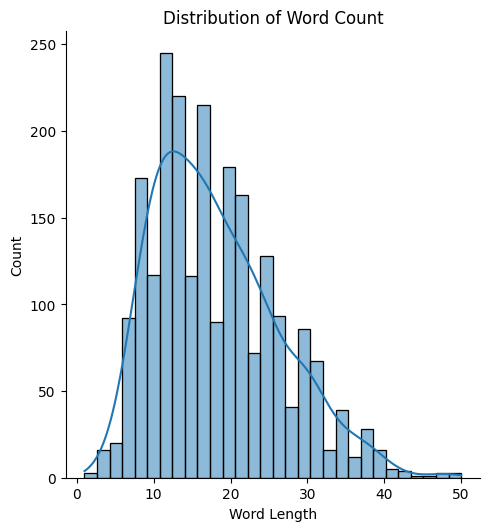

In [6]:
# Plot distribution of word count
sns.displot(word_count, kde=True)
plt.title('Distribution of Word Count')
plt.xlabel('Word Length')
plt.show()

The word count distribution appears to be normally distributed with the highest frequencies around 15-20 words. 

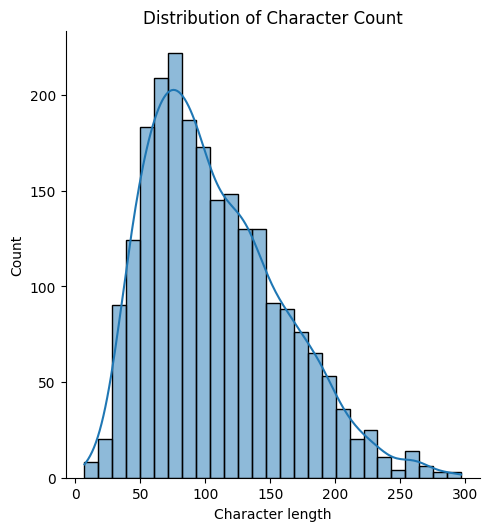

In [9]:
# Plot distribution of character count
sns.displot(character_count, kde=True)
plt.title('Distribution of Character Count')
plt.xlabel('Character length')
plt.show()

Similarly, the distribution of character length appears to be normally distributed with the highest frequencies around 60-100 characters. 

**Distribution of sentiment**

[]

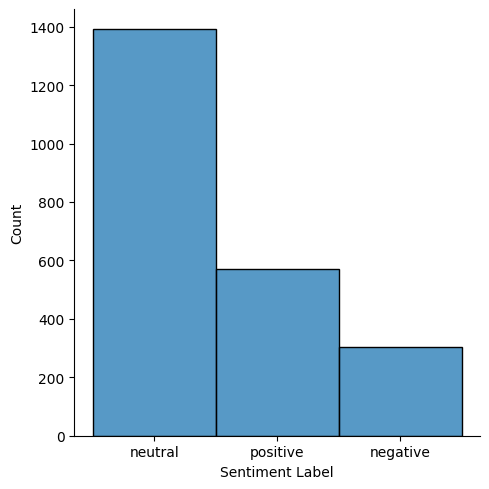

In [18]:
# Plot distribution of sentiment labels
sns.displot(df['Sentiment'])
plt.xlabel('Sentiment Label')
plt.plot()

Most of news articles provided in the dataset were `neutral` labels. From first glance, the data is considered imbalance so we may need to assign weights accordingly prior to modeling. This statistical adjustment will help improve the accuracy of the classification model and will attempt to alleviate overfitting.

## Data Preparation

The next step will be to transform our sentiment labels into a numerical data type so it is compatible with our transformer. To do this, the OneHotEncoder module from `sklearn` library will be used. As a result, there will be three columns designated for each sentiment label.

In [19]:
from sklearn.preprocessing import OneHotEncoder

y = df['Sentiment']

ohe = OneHotEncoder(categories=[['neutral', 'positive', 'negative']])
y_encoded = ohe.fit_transform(y.values.reshape(-1,1))

df_encoded = pd.concat([df.drop('Sentiment', axis=1), 
                        pd.DataFrame(y_encoded.toarray(),
                                     columns=ohe.get_feature_names_out())], axis=1)

df_encoded.columns = [['New Article', 'Neutral', 'Positive', 'Negative']]
display(df_encoded.head(5))

,New Article,Neutral,Positive,Negative
0,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .",1.0,0.0,0.0
1,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",0.0,1.0,0.0
2,"In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .",0.0,1.0,0.0
3,Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .,0.0,1.0,0.0
4,"Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .",0.0,1.0,0.0


Once the target variable is one-hot encoded, we can now create our training and testing sets for modeling. It is general practice to split 80/20, and so will be the case for our splitting purposes.

In [47]:
df_train = df_encoded.sample(frac=0.8, random_state=3, replace=False)
df_validation = df_encoded.drop(df_train.index)

Now, we will calculate the weights for each class in the training set.  

In [48]:
# Counts for each sentiment label
print(df_train[['Neutral', 'Positive', 'Negative']].value_counts())

(Neutral,)  (Positive,)  (Negative,)
1.0         0.0          0.0            1105
0.0         1.0          0.0             458
            0.0          1.0             248
dtype: int64


In [49]:
# Calculate training set weights
neutral_wt = (len(df_train)) / (3 * df_train[df_train['Neutral'] == 1].count())
positive_wt = (len(df_train)) / (3 * df_train[df_train['Positive'] == 1].count())
negative_wt = (len(df_train)) / (3 * df_train[df_train['Negative'] == 1].count())

## Transformers

In [2]:
from transformers import AlbertTokenizer, AlbertModel
from transformers import InputExample, InputFeatures

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = AlbertModel.from_pretrained('albert-base-v2')

ImportError: 
AlbertTokenizer requires the SentencePiece library but it was not found in your environment. Checkout the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.
